In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras_tuner as kt 

# Load the data
data = pd.read_csv('final_data.csv')
data = data.dropna()
data = data.drop_duplicates()
data = data.reset_index(drop=True)

# Preprocess the data like for randomForest_simplified.ipynb
# Encode the sequence
# Define the 20 standard amino acids and include non-standard ones
amino_acids = 'ACDEFGHIKLMNPQRSTVWYU'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}


def one_hot_encode(seq, max_length):
    # Pad the sequence to the maximum length with 'X' (unknown amino acid)
    padded_seq = seq.ljust(max_length, 'X')
    int_encoded = [aa_to_int.get(aa, len(amino_acids)) for aa in
                   padded_seq]  # Use a default index for unknown amino acids
    one_hot_encoded = np.zeros((max_length, len(amino_acids) + 1))  # +1 for the unknown amino acid
    for i, value in enumerate(int_encoded):
        one_hot_encoded[i, value] = 1
    return one_hot_encoded


# Determine the maximum sequence length
max_seq_length = max(data['Sequence'].apply(len))

# Encode the sequences
one_hot_encoded_sequences = np.array([one_hot_encode(seq, max_seq_length) for seq in data['Sequence']])

# Initialize the label encoder for charge states
label_encoder = LabelEncoder()
encoded_charge_states = label_encoder.fit_transform(data['Charge'].tolist())

# Reshape charge states to 3D, so that they match the dimensions of the one-hot-encoded sequences
# We repeat the charge value along the sequence length (max_seq_length) so that each sequence position has the charge value
encoded_charge_states_3d = np.repeat(encoded_charge_states[:, np.newaxis], max_seq_length, axis=1)

# Expand the charge states along the feature axis (the last axis) to match the shape of the one-hot-encoded sequences
encoded_charge_states_3d = np.expand_dims(encoded_charge_states_3d, axis=-1)

# Combine the one-hot encoded sequences and charge states into a single input array
# Concatenate along the feature axis (the last dimension)
X_combined = np.concatenate([one_hot_encoded_sequences, encoded_charge_states_3d], axis=2)

# The target variable (y) is the CCS value and will be normalized relative to the min and maximum CCS value
ccs_values = data['CCS'].values
normalized_ccs_values = (ccs_values - ccs_values.min()) / (ccs_values.max() - ccs_values.min())
y = normalized_ccs_values



In [22]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Assuming X_train and X_test are already defined and contain the combined sequences and charge states

# Extract sequences and charge states from X_train and X_test
train_sequences = np.argmax(X_train[:, :, :-1], axis=2)
train_charge_states = X_train[:, 0, -1].astype(int)

test_sequences = np.argmax(X_test[:, :, :-1], axis=2)
test_charge_states = X_test[:, 0, -1].astype(int)

# Create unique identifiers for each data point by combining sequence and charge state
train_unique_ids = {f"{seq}_{charge}" for seq, charge in zip(train_sequences, train_charge_states)}
test_unique_ids = {f"{seq}_{charge}" for seq, charge in zip(test_sequences, test_charge_states)}

# Identify overlapping and non-overlapping data points
overlap = train_unique_ids.intersection(test_unique_ids)
non_overlap = len(test_unique_ids) - len(overlap)

print(f"Number of overlapping data points: {len(overlap)}")
print(f"Number of non-overlapping data points: {non_overlap}")


# # Split the data ensuring no overlap between training and test sets
# unique_sequences = data['Sequence'].unique()
# train_sequences, test_sequences = train_test_split(unique_sequences, test_size=0.2, random_state=42)
# 
# # Filter the original dataset to create training and test sets
# train_data = data[data['Sequence'].isin(train_sequences)]
# test_data = data[data['Sequence'].isin(test_sequences)]
# 
# # Separate features and target variable
# X_train = X_combined[train_data.index]
# y_train = y[train_data.index]
# X_test = X_combined[test_data.index]
# y_test = y[test_data.index]
# 
# # Verify the split
# print(f"Number of unique sequences in training set: {len(train_sequences)}")
# print(f"Number of unique sequences in test set: {len(test_sequences)}")
# print(f"Number of overlapping sequences: {len(set(train_sequences).intersection(set(test_sequences)))}")


Number of overlapping data points: 0
Number of non-overlapping data points: 29162


In [23]:

# Build the model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Correct input shape: (timesteps, features)
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output for regression
model.compile(optimizer=Adam(0.001), loss='mean_squared_error')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping], shuffle=False)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

r2 = r2_score(y_test, y_pred)
print(f"R^2: {r2}")


Epoch 1/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 0.0048 - val_loss: 4.2209e-04
Epoch 2/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 6.8412e-04 - val_loss: 4.2097e-04
Epoch 3/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 6.3522e-04 - val_loss: 3.7325e-04
Epoch 4/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 6.1076e-04 - val_loss: 4.7022e-04
Epoch 5/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 6.0178e-04 - val_loss: 3.3849e-04
912/912 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Mean Squared Error: 0.0003384931060607919
R^2: 0.9910122158249075


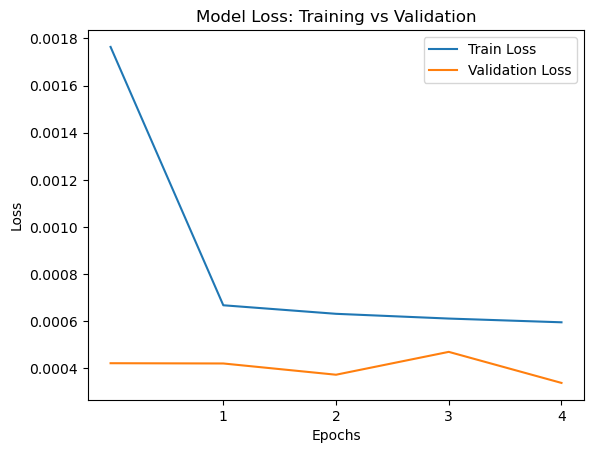

In [24]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels for the axes
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a title for clarity
plt.title('Model Loss: Training vs Validation')

# Add a legend to differentiate between train and validation losses
plt.legend()

# Set x-ticks to show full numbers starting from 1
epochs = range(1, len(history.history['loss']))
plt.xticks(epochs)

# Display the plot
plt.show()


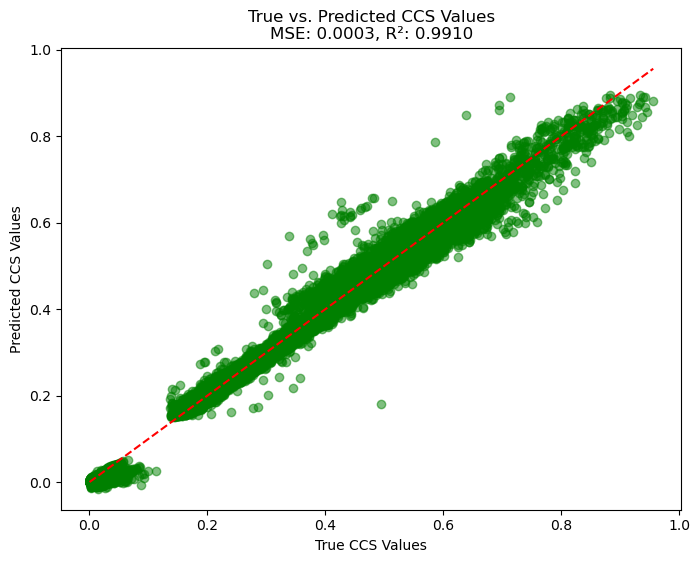

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='green', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True CCS Values')
plt.ylabel('Predicted CCS Values')
plt.title(f'True vs. Predicted CCS Values\nMSE: {mse:.4f}, R²: {r2:.4f}')
plt.show()

In [27]:
import tensorflow as tf
# Load and preprocess data (same as in your script)
# Ensure to use your data preparation and one-hot encoding here.


# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    model.add(LSTM(lstm_units))

    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.6, step=0.2)
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')

    return model

# Initialize the Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='lstm_tuning'
)

tuner.search_space_summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
log_dir = "logs/hparam_tuning"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

tuner.search(X_train, y_train,
             epochs=5,
             batch_size=32,
             validation_data=(X_test, y_test),
             callbacks=[early_stopping],
             shuffle=False)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best LSTM Units: {best_hps.get('lstm_units')}")
print(f"Best Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")

best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(X_train, y_train,
                         epochs=5,
                         batch_size=32,
                         validation_data=(X_test, y_test),
                         callbacks=[early_stopping],
                         shuffle=False)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error after tuning: {mse}")

r2 = r2_score(y_test, y_pred)
print(f"R^2 after tuning: {r2}")

# To visualize the results, run the following command in your terminal:
# tensorboard --logdir logs/hparam_tuning

Reloading Tuner from hyperparam_tuning/lstm_tuning/tuner0.json
Search space summary
Default search space size: 3
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Best LSTM Units: 64
Best Dropout Rate: 0.1
Best Learning Rate: 0.01
Epoch 1/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 0.0058 - val_loss: 4.1936e-04
Epoch 2/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 5.5857e-04 - val_loss: 3.3664e-04
Epoch 3/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 5.3487e-04 - val_loss: 4.1006e-04
Epoch 4/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - loss: 5.0479e-04 - val_loss: 3.5039e-04
Epoch 5/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - loss: 4.8359e-04 - val_lo